Import / install modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyro
import torch
from torch.distributions import constraints, transform_to
import pyro.contrib.gp as gp
import pyro.distributions as dist
pyro.set_rng_seed(0)
torch.set_default_dtype(torch.float64)

In [2]:
# find gpu if available, and name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

# show device info
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cpu
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Generate synthetic data:

In [3]:
NUM_POINTS = 500 # number of observation points
NOISE_LEVEL = 2  # noise level
XRANGE = [-30, 60] # range of x values

# Generate noisy data from a known function
f = lambda x: (2. * x[:, 0] * (1. + np.sin(.5 * x[:, 0])) + 5.)
X_true = np.linspace(XRANGE[0], XRANGE[1], NUM_POINTS)[..., np.newaxis]
y_true = f(X_true) + NOISE_LEVEL*np.random.normal(size=NUM_POINTS)
# Convert to torch tensors
X = torch.from_numpy(X_true)
y = torch.from_numpy(y_true)

In [4]:
torch.cuda.empty_cache()
pyro.clear_param_store()

num_steps = 3000

class Matern12(pyro.contrib.gp.kernels.Isotropy):
    def __init__(self, input_dim, variance=None, lengthscale=None, active_dims=None):
        super().__init__(input_dim, variance, lengthscale, active_dims)

    def forward(self, X, Z=None, diag=False):
        if diag:
            return self._diag(X)

        r = self._scaled_dist(X, Z)
        return self.variance * torch.exp(-r)

# initialize kernel
kernel = pyro.contrib.gp.kernels.Matern52(1)
# Set constraints
kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(20.)))

# run sparse gaussian regression
sgpr = gp.models.GPRegression(X, y, kernel, jitter=1.0e-5)
#optimizer = torch.optim.Adam(sgpr.parameters(), lr=1e-2)
optimizer = torch.optim.LBFGS(sgpr.parameters(), lr=1e-2)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(sgpr.model, sgpr.guide)
    loss.backward()
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(sgpr.model, sgpr.guide)
        loss.backward()
        return loss
    optimizer.step(closure)
    losses.append(loss.item())
    if i % 100 == 0 or i == num_steps-1:
        print("lengthscale_map: {}   lengthscale: {}".format(
            sgpr.kernel.lengthscale_map.detach().item(),
            sgpr.kernel.lengthscale.item()))
print("Final lengthscale values...")
print("lengthscale_map: {}   lengthscale: {}".format(
            sgpr.kernel.lengthscale_map.detach().item(),
            sgpr.kernel.lengthscale.item()))

/home/tristan/miniforge3/envs/rapids-24.08/lib/python3.11/site-packages/pyro/contrib/gp/parameterized.py:106: UserWarning: The method `self.set_prior(lengthscale, prior)` has been deprecated in favor of `self.lengthscale = PyroSample(prior)`.
  warnings.warn(


lengthscale_map: 19.4402117986074   lengthscale: 14.448577423595971
lengthscale_map: 19.999989033235718   lengthscale: 9.728275919421566
lengthscale_map: 19.999989032950342   lengthscale: 18.494205998317245
lengthscale_map: 19.999989032950342   lengthscale: 13.255458282332532
lengthscale_map: 19.999989032950342   lengthscale: 16.03180995142577
lengthscale_map: 19.999989032950342   lengthscale: 4.3935173288142675
lengthscale_map: 19.999989032950342   lengthscale: 7.6710448634846395
lengthscale_map: 19.999989032950342   lengthscale: 12.045477476343915
lengthscale_map: 19.999989032950342   lengthscale: 6.476481950586853
lengthscale_map: 19.999989032950342   lengthscale: 9.60450812874117
lengthscale_map: 19.999989032950342   lengthscale: 4.359190997870567
lengthscale_map: 19.999989032950342   lengthscale: 7.750068408446822
lengthscale_map: 19.999989032950342   lengthscale: 12.816199724911026
lengthscale_map: 19.999989032950342   lengthscale: 10.155119614852463
lengthscale_map: 19.999989032

Make "prediction":

In [7]:
Xtest = np.linspace(XRANGE[0], XRANGE[1], NUM_POINTS*2)[..., np.newaxis]
Xtest = torch.from_numpy(Xtest)
with torch.no_grad():
    mean, cov = sgpr(Xtest, full_cov=True, noiseless=False)
    sd = cov.diag().sqrt()

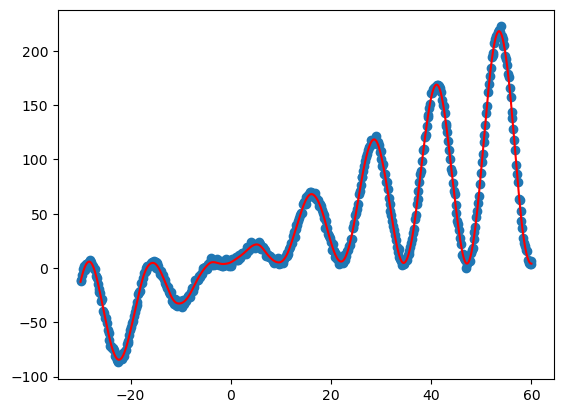

In [8]:
plt.plot(Xtest, mean, zorder=1, c='r')
plt.scatter(X_true, y_true, zorder=0)